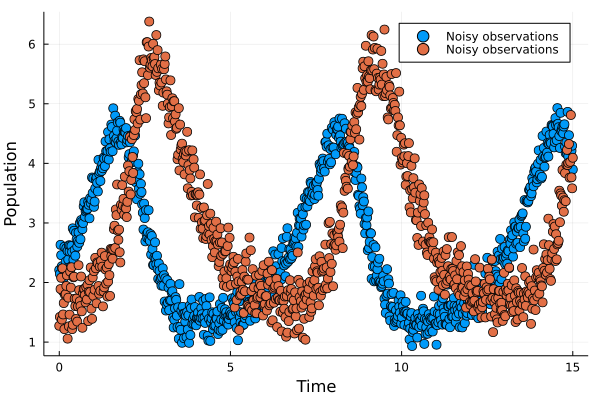

In [1]:
# Reading a JSON input and applying modelling techniques based on Neural ODEs
#-----------------------------------------------------------------------------------------------------------------------------------
__author__ = "Christian Simonis"
__copyright__ = "Copyright 2022"
__version__ = "1.0"
__maintainer__ = "Christian Simonis"
__email__ = "christian.Simonis.1989@gmail.com"
__status__ = "work in progress"

#-----------------------------------------------------------------------------------------------------------------------------------

# '''
#THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
#AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
#IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
#ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS
#BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY,
#OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
#SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
#INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
#CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
#ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF
#THE POSSIBILITY OF SUCH DAMAGE.
#"""
#-----------------------------------------------------------------------------------------------------------------------------------

using JSON                     # Copyright (c) 2002: JSON.org, 2012–2016: Avik Sengupta, Stefan Karpinski, David de Laat, Dirk Gadsen, Milo Yip and other contributors – https://github.com/JuliaLang/JSON.jl/contributors and https://github.com/miloyip/nativejson-benchmark/contributors, https://github.com/JuliaIO/JSON.jl/blob/master/LICENSE.md
using Plots                    # Copyright (c) 2015: Thomas Breloff., https://github.com/JuliaPlots/Plots.jl/blob/master/LICENSE.md
using Random                   # Copyright (c) 2009-2021: Jeff Bezanson, Stefan Karpinski, Viral B. Shah, and other contributors: https://github.com/JuliaLang/julia/contributors, https://github.com/JuliaLang/julia/blob/master/LICENSE.md, https://github.com/JuliaLang/julia/blob/master/stdlib/Random/docs/src/index.md
using DiffEqFlux               # Copyright (c) 2018-20 SciML, Julia Computing, https://github.com/SciML/DiffEqFlux.jl/blob/master/LICENSE
using OrdinaryDiffEq           # Copyright (c) 2016-2020: ChrisRackauckas, Yingbo Ma, Julia Computing Inc, and other contributors: https://github.com/SciML/OrdinaryDiffEq.jl/graphs/contributors, https://github.com/SciML/OrdinaryDiffEq.jl/blob/master/LICENSE.md
using Flux                     # Copyright (c) 2016-19: Julia Computing, INc., Mike Innes and Contributors, https://github.com/FluxML/Flux.jl/blob/master/LICENSE.md
using Optim                    # Copyright (c) 2012: John Myles White, Tim Holy, and other contributors. Copyright (c) 2016: Patrick Kofod Mogensen, John Myles White, Tim Holy, and other contributors. Copyright (c) 2017: Patrick Kofod Mogensen, Asbjørn Nilsen Riseth, John Myles White, Tim Holy, and other contributors., https://github.com/JuliaNLSolvers/Optim.jl/blob/master/LICENSE.md
using DifferentialEquations    # Copyright (c) 2016: Chris Rackauckas, Julia Computing., https://github.com/SciML/DifferentialEquations.jl/blob/master/LICENSE.md

#-----------------------------------------------------------------------------------------------------------------------------------

#Ramdom seed
Random.seed!(3); 

#Load Json data
loaded_file = JSON.parsefile("data.json");


#Extract content from time series data
n = length(loaded_file) 

Time_series_data = Array{Float64}(undef,n, 3);
for i in 1:n
    for j in 1:3
       Time_series_data[i,j] = loaded_file[i][j];
    end   
end

# Time series:
t = Time_series_data[:,1];       # time
data = Time_series_data[:,2:3]'; # population data



#Visualize time series data
scatter(t,data', markersize=5, label=["Noisy observations" "Noisy observations"], xlabel = "Time",ylabel = "Population")

In [2]:
# Neural ODE
tspan = (minimum(t),maximum(t));
prob_neuralode = NeuralODE(FastChain( FastDense(2, 15, tanh), FastDense(15, 2)), tspan, Tsit5(), saveat = t);


function predict_neuralode(p)
  Array(prob_neuralode(u, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, data .- pred)
    return loss, pred
end

# Initial conditions
u     = data[:,1];                #u0
p     = [0.1 , 0.5 , 0.1 , 0.5];  #p0

In [3]:
# Callback definition
list_plots = []
iter = 0
callback = function (p, l, pred; doplot = false) #set "doplot = true", if you want to see the visualization during training
  global list_plots, iter

  if iter == 0
    list_plots = [];
  end
  iter += 1;

  display(l);

  # plot current prediction against data
  plt = scatter(t, data[1,:])
  scatter!(plt, t, pred[1,:])
  scatter!(plt, t, data[2,:])
  scatter!(plt, t, pred[2,:])  
  
  push!(list_plots, plt)
  if doplot
    display(plot(plt))
  end

  return false
end


# Training with SciML
result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, prob_neuralode.p,
                                          ADAM(0.05),
                                          maxiters = 170, cb = callback);


result_neuralode_tuned = DiffEqFlux.sciml_train(loss_neuralode,
                                           result_neuralode.minimizer,
                                           LBFGS(),  cb = callback);

98541.57317126215

17862.226493863647

11953.094822238836

10328.087751854922

8488.73323196112

6009.142802182219

3110.161250970903

6883.888955700886

3411.8496099890226

2748.5377308038333

3292.932184497302

3682.229240157856

3829.4338343182176

3789.156784375254

3617.331928378183

3363.705656588849

3078.0614575391637

2815.7803496063107

2637.7226383337716

2595.5712343182004

2693.0613870340712

2844.6202483214824

2913.0661301731707

2840.2438055760053

2694.0069617220934

2569.289651749099

2507.7394986404684

2502.219067516071

2527.909749679231

2561.5281348988237

2587.4483274010554

2597.8130795805027

2590.9592100541286

2569.7335187739527

2539.9953181326164

2509.1581731823508

2484.554501345553

2471.567457411282

2471.846045703335

2482.3822119006704

2496.379854585214

2506.1379599289176

2506.6849854422926

2497.919620176659

2483.8982302067216

2470.060381821282

2460.454019827462

2456.4375081197218

2456.955556212418

2459.650988471639

2462.048104528333

2462.3886853384965

2460.015823406419

2455.360902768803

2449.6363400825353

2444.3452477881046

2440.732164151812

2439.330459673796

2439.773563023214

2440.980926194915

2441.6732410341288

2440.9770466741807

2438.792574704672

2435.7305942941375

2432.698355341547

2430.4145385650063

2429.118681258964

2428.568888196417

2428.2516007768118

2427.6557169078687

2426.48405060173

2424.737080514792

2422.6642170272034

2420.622318964126

2418.906644190308

2417.625193855766

2416.6697133746084

2415.793281373658

2414.7507450953053

2413.423733740493

2411.8628530559786

2410.2330955356874

2408.706527823925

2407.3702357017182

2406.1960313267327

2405.0752623314374

2403.8878703182963

2402.5648500037414

2401.1148456470773

2399.6080417366975

2398.1309530293506

2396.738258278311

2395.4270773794933

2394.145888835744

2392.830232472456

2391.4420434466347

2389.988478403764

2388.5109358861796

2387.0549406829623

2385.6421687809925

2384.261466132054

2382.881133931454

2381.471491519168

2380.0225946283495

2378.5471385670176

2377.068945055763

2375.6060214534536

2374.159529086001

2372.7152565492925

2371.255290271677

2369.770786553275

2368.2668960724686

2366.7571931105417

2365.2530278021213

2363.7560630422695

2362.258734353485

2360.7512180068034

2359.2288807048017

2357.6948561492827

2356.1566523460006

2354.6199597983104

2353.0846674708487

2351.545799079923

2349.9980426783786

2348.439958505898

2346.874492442714

2345.3059699760115

2343.736382861984

2342.164178404597

2340.5860555736285

2338.999942655827

2337.4064812068336

2335.8080001705794

2334.206194580052

2332.6006459577493

2330.989339888252

2329.370470094317

2327.743798133229

2326.1103493165083

2324.471017663207

2322.8254541265155

2321.1722204521593

2319.5098470478097

2317.8377337928423

2316.156038265778

2314.464820073755

2312.7633827890036

2311.050346100161

2309.324364014777

2307.5845911990828

2305.83057274806

2304.0616865593056

2302.276795482369

2300.4743934486055

2298.6530378777015

2296.811592051889

2294.9490616774037

2293.0642315776095

2291.1555628982824

2289.221367157725

2287.2600192797413

2285.2700596886248

2283.2499986114535

2281.1981818209297

2279.1127464111223

2276.9917833892328

2274.833456961691

2272.635957285626

2270.397411106361

2268.115806358287

2268.115806358287

2268.115806358287

2179.0252425193685

2138.1905176012697

2098.9457821275214

1942.9582098398023

1764.156765658117

1682.4834912736285

1668.99897191654

1626.7961618346535

1605.1116829001007

1591.2384535724118

1560.2126785063995

1512.5308981381863

1392.9262817253825

1329.5986753013344

1216.4953573858008

1071.6186059005477

1050.342181577426

1012.7166015326584

980.7530677614386

970.9864705961297

958.127777406977

911.3919801965279

860.8888041352179

780.5890227445607

711.5892087988639

700.0071678399459

695.334370082358

683.2775725710101

664.4925913034144

652.8163844950886

631.5565469565308

625.6562844696025

609.5520172942395

589.68667634025

574.7112549597972

565.1404720162549

549.044095104364

543.8453156706239

525.8865965143924

522.1185262982343

519.6989453099995

516.2744386599036

510.0242556745475

502.77861116132914

500.7130432903343

498.5636373901235

494.61405144158215

488.4431858364726

482.15182621387964

469.8285425653322

466.7082424432857

464.12258466010445

460.4982279026734

455.4105951217382

448.8894653099527

441.60459125990735

439.94352380008195

437.7630083338351

435.78827717290017

434.57743696739647

429.2919181871631

418.41215877641855

415.479030798332

408.29716112031724

405.4651013610208

396.2855608912497

394.32747372231455

390.2836289861485

384.6429582548827

368.6906896049337

365.8570535866485

362.97130141864545

361.55455077032445

359.9045138661841

357.5113743664764

354.1768824309914

346.4450600052918

345.58891606706624

340.7633184424501

337.66475241836935

337.0541057874753

335.87600197085754

334.85144193155975

334.6184610420533

330.7832608376384

322.0867949537645

319.6503693498764

317.26389580863776

311.4701809353515

308.87948814196255

306.7298841443288

303.7246769529437

300.3827711937739

296.3337353768479

293.4048423348613

291.8808848484242

291.3650940476488

290.59573106127755

289.38828736903884

288.5821795439505

286.96307367008876

286.19488370812246

285.42761141868726

284.570412100593

283.95374914897684

283.808581988925

283.6639415380191

283.16235111229435

282.6489478489492

281.95269229758543

281.6087337639105

280.91311876036445

279.55874122275065

278.4579189767334

277.41725863374717

274.03170932824025

270.62059914377693

265.8977551951697

263.23312597305915

255.56604478287102

250.82393707475916

243.52083025783153

242.09294329460548

236.3561332428846

227.0530818953945

219.56266176297456

216.35528626929118

215.11814151534497

213.17670501968485

211.28385712031388

209.91621086548983

207.7323922087077

206.24322354042022

204.95579115573167

202.7529980822389

199.86102903095457

199.00294048753665

198.05608497751473

196.93040848613668

195.89732539199187

195.15179964717322

194.7864697402349

193.71406614293318

192.67589783847623

191.4102427945871

191.2572025535422

191.0486705610163

190.92340947047876

190.85637896008876

190.7000654579166

190.63909467477546

190.31113892292632

190.22714451297247

190.13370503198587

189.8889776513152

189.712009883833

189.53983020985214

189.3586461774688

188.56166268719969

187.99576098443373

187.55093559766874

187.50044073965924

186.94037043655175

185.41170195746835

184.18971341577912

183.5014935367608

182.15232087559343

180.31963915823678

177.60127943175934

174.9160383864305

171.35260034014985

169.28022878402288

167.3955062771231

166.5991899269228

166.12546910341206

165.31911827277932

165.31263365724428

165.2453033601106

165.06063080520477

164.9556040376021

164.83556658715435

164.64262061035947

164.59265657964323

164.54359901996366

164.50911246430184

164.5092418223611

164.50922978038125

164.46681371986074

164.41235691128827

164.22648288863684

164.22648288863684

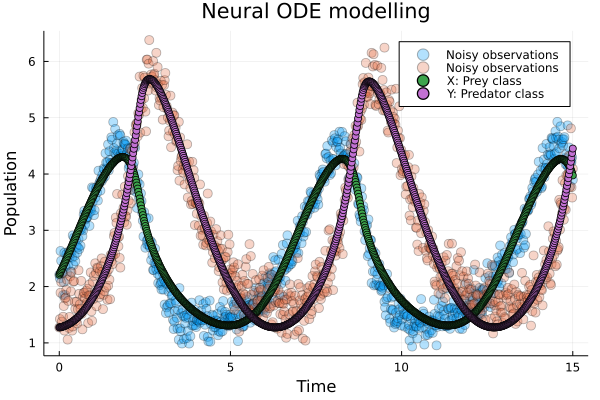

In [4]:
# Visualization of results
pl = scatter(t,data',markersize=5, label=["Noisy observations" "Noisy observations"], alpha = 0.3, xlabel = "Time",ylabel = "Population", title = "Neural ODE modelling")
display(scatter!(pl, t, loss_neuralode(result_neuralode_tuned.minimizer)[2]', label=["X: Prey class" "Y: Predator class"]))